In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 04, ASTR 596: Fundamentals of Data Science


## A Gentle introduction to Optimization

### Gautham Narayan 
##### <gsn@illinois.edu>



## Recap: Statistical Modeling "Wisdom"

Four Questions for a Bayesian:

1. What is the model?

2. What is the likelihood? Derive $L(\theta)$ from your sampling distribution $P(D|\theta)$

3. What are your priors $P(\theta)$?

4. How do you optimize/sample this objective function to model the data?

We've talked a lot about Q1 and Q2, less about Q3, and for Q4 we've been working through different methods: grid-search, gradient descent (i.e. scipy's fmin/optimize) 

We'll return to Q3, but to make progress, we need to deal with Q4 first because we're limiting the sorts of problems we can deal with

So far, we've restricted ourselves to inferences with:
* exact solutions - rare!
* linear-izable functions - because these are convex, and minimum is the global minimum!
* low-dimensional parameter spaces - limiting!

We can think of more complicated scenarios:

![Posteriors](./posteriors.png)

![CMD](cmd_all.png)

![Planet Posterior](Planet_posterior.png)

# Newton's Method (sometimes Newton-Raphson)

Goal: Want to find $x_c$, such that $f(x = x_c) = 0$ 

1. Make an initial guess that is half-way reasonable 

2. Iterate $ x_{n+1} = x_n - f(x_n)/f^\prime(x_n) $


![Newton-Raphson](NewtonRaphson.png)


Many function minimization algorithms are based on the fundamental idea of **gradient descent.** 

If a function f is differentiable, then at every point, the opposite of its gradient points to the direction of the greatest decrease rate of the function. 

By following this direction, we can expect to find a local minimum.


![Newton-Raphson](NewtonRaphson.png)


If you can compute an analytical expression of the gradient, you should provide it to the minimization routine. Otherwise, the algorithm will compute an approximation of the gradient that may not be reliable.

Newton's method can also be used in this context of function minimization. 

The idea is to find a root of the (derivative of the Likelihood with Newton's method (i.e. $f = L^{\prime}$), thereby making use of the second derivative . 

In other words, we approximate the likelihood $L$ with a quadratic function instead of a linear function. 

In multiple dimensions, this is done by computing the Hessian (second derivatives) of $L$. 

By performing this operation iteratively, we can expect the algorithm to converge towards a local minimum.

This is what scipy.optimize is doing by default (actually now they've switched to BFGS) which is a Quasi-Newton method but not all that different.

# In class exercise:

Let's create a complicated e.g. of a likelihood in 2 dimensions.
You get to use scipy's optimize Nelder-Mead to figure out the minimum of this function.

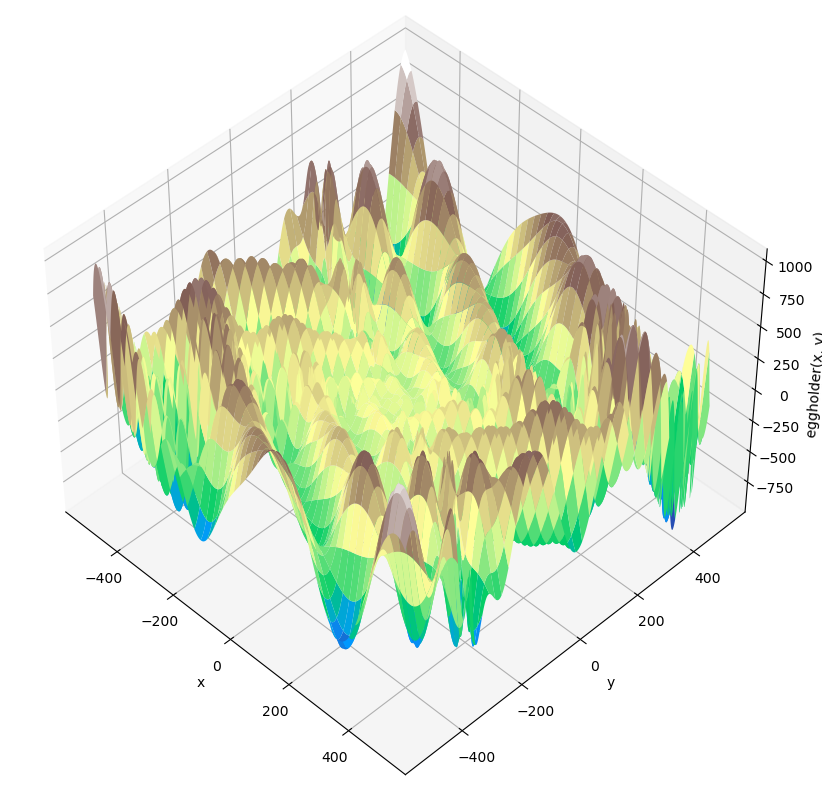

In [13]:
# RUN THIS
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
plt.rcParams['figure.figsize'] = [10, 10]
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
import scipy


def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))\
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)');


In [23]:
# use optimize.minimize to try to find the minimum
# try it 10 times with different starting guesses
# print out the minimum value, and the x, y location of the minimum
# since you already have the true function, get the minimum value 
# and the location of the minimum of your x, y grid


guess = st.uniform.rvs(loc=-512,scale=1024,size=2)
res=scipy.optimize.minimize(eggholder,guess)
res.x
# you should notice how the minimum value is all over the place based on your starting guess.

array([-171.13930856,  -96.11909836])

In [24]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -211.1804874434639
        x: [-1.711e+02 -9.612e+01]
      nit: 8
      jac: [-1.907e-06  1.907e-06]
 hess_inv: [[ 5.696e+00  3.774e+00]
            [ 3.774e+00  4.492e+00]]
     nfev: 45
     njev: 15

# Global Optimizers (use if you have a complex problem but low dimensionality)


Generally, these use a two step approach - something to take large steps to avoid local minima + another step to find the minima near the best of the big steps.

# Simulated annealing

Mimics the physical process of heating a material and then slowly lowering the temperature to decrease defects, thus minimizing the system energy.

At each iteration of the simulated annealing algorithm, a new point is randomly generated. 

The distance of the new point from the current point, or the extent of the search, is based on a probability distribution 

## $$ P = \exp(-\Delta L/kT) $$



The algorithm accepts all new points that lower the objective, but also, with a certain probability, points that raise the objective. 

By accepting points that raise the objective, the algorithm avoids being trapped in local minima, and is able to explore globally for more possible solutions.

![Simulated Annealing](sim_annealing_flow.png)


An annealing schedule is selected to systematically decrease the temperature as the algorithm proceeds. 

As the temperature decreases, the algorithm reduces the extent of its search to converge to a minimum.

Basin-hopping algorithm is a stochastic algorithm that seeks a global minimum by combining random perturbation of the positions and local minimization.

`scipy.optimize.basinhopping`

![Basin Hopping](basin_hopping.jpg)

Simplicial homology global optimization (SHGO) is another good option, particularly since it also returns all other local and global minimum in addition to the global minimum. 

It's using "novel, rigorously proven" methods that detect the homological properties of the objective function surface). 

![SHGO](shgo.svg)

## Use Basin-hopping, simulated annealing and SHGO to solve the eggholder problem

In [4]:
class MyBounds(object):
    def __init__(self, xmax=[512, 512], xmin=[-512,-512] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

bounds = MyBounds()
res1 = optimize.basinhopping(eggholder, [st.uniform.rvs(loc=-512, scale=1024, size=2)],\
                             niter=10000, T=1, accept_test=bounds, seed=42)
print('Basin Hopping')
print(res1)

Basin Hopping
                        fun: -564.2820191516741
 lowest_optimization_result:       fun: -564.2820191516741
 hess_inv: array([[ 8.16920857, -4.227524  ],
       [-4.227524  ,  6.25781317]])
      jac: array([-7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 13
     njev: 19
   status: 0
  success: True
        x: array([ -20.55777522, -596.89508548])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 93
                       nfev: 132911
                        nit: 10000
                       njev: 44195
                          x: array([ -20.55777522, -596.89508548])


In [5]:
print('-------------')
res2 = optimize.shgo(eggholder, bounds=[(-512, 512), (-512, 512)], n=30, sampling_method='sobol')
print('SHGO')
print(res2)

-------------
SHGO
     fun: -582.3062800548453
    funl: array([-582.30628005, -565.99778097, -559.78685655, -557.36868733,
       -426.48799655, -410.98477763])
 message: 'Optimization terminated successfully.'
    nfev: 278
     nit: 2
   nlfev: 246
   nlhev: 0
   nljev: 65
 success: True
       x: array([324.99187533, 216.0475439 ])
      xl: array([[ 324.99187533,  216.0475439 ],
       [-105.87688911,  423.15323845],
       [-242.97926   ,  274.38030925],
       [-506.25823477,    6.3131022 ],
       [  91.00920901, -391.283763  ],
       [-219.40612786, -244.06020508]])


# Curse of Dimensionality

![Curse of Dimensionality](ndim.png)

You'll do something very different on your 2nd homework assignment

- you'll simulate the experiment over and over, drawing random samples from a distribution of your parameter

- you'll pick those draws where the simulated experiment matched your real data (Alice has won 5 games by game 8, Bob wins at the end) 
    - i.e. you rejected the others

- you determined the frequency of the outcome you are interested in happening.

A history of the Monte Carlo method and the Manhattan project:
https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-88-9068


In general, evaluating the posterior throughout the entire parameter space is too costly. 

We want to focus resources on mapping the posterior where it is non-tiny. 

**Generating samples from the posterior itself automatically accomplishes this.**

### Sampling and numerical integration

Almost always, we are ultimately interested in *integrals* of the posterior, i.e. marginal distributions of parameters. The tasks of Monte Carlo sampling and **Monte Carlo integration** are essentially indistinguishable. (Similar machinery is useful for difficult optimization problems.)

The essence of MC integration:

$\int w(x)\,p(x)\,dx = \int w(x)\,dP(x) \approx \overline{w(x_i)}; ~ x_i\sim P$

i.e., if we can factor the integrand into a PDF and a weight, and sample from the PDF, then our integral becomes an _average over the samples_.

In other words, given a list of samples of $\theta$ from $p(\theta)$,
* the marginalized 1D posterior for $\theta_0$ is estimated by making a histogram of $\theta_0$ samples
* the marginalized 2D posterior for $\theta_0,\theta_1$ is estimated from a 2D histogram of $\theta_0,\theta_1$ samples
* statistics like the mean or percentiles of the posterior are estimated directly from the samples

All of these computations would be weighted if $w(\theta)\neq1$.

# Simple Example

Area of a rectangle = Base $\times$ Height
Area of a triangle = 1/2 Base $\times$ Height
What about the area of this?

![Messy Area](messy_area.png)

![Conditional probability](conditional_prob.png)

![Conditional probability](conditional_prob2.png)

## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

$p(\theta|x) \propto p(x|\theta)\,p(\theta)$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. However, refinements of this approach lead to some of the advanced algorithms we'll cover later.

For now, we'll focus on the most common methods, which use a unit weight function (i.e. obtain draws directly from the posterior).

But first, a bit more context re: random number generation.

## Random number generation
Useful terms to know:

* Random: predictable only in the sense of following a PDF

* Pseudorandom: not random, but "unpredictable enough" for practical purposes. Various computer algorithms produce pseudorandom sequences that approximate the uniform distribution on [0,1).

* Quasirandom: sequence that doesn't even pretend to be random, but does converge to a target PDF *more quickly* than a random or pseudorandom process would

Here we assume that we have a reliable source of uniform pseudorandom numbers, and want to turn these into samples of another PDF.

Two simple approaches are
1. Rejection sampling
2. Inverse Transform

# In class exercise - rejection sampling

You'll use rejection sampling on HW2

- Draw x, y points from a uniform distribution between 0 and 1
- Sample size = [10, 1,000, 100,000]
- calculate r = sqrt(x^2 + y^2)
- reject if r > 1, else accept
- plot the accepted points in red and the rejected points in blue in the x-y plane
- calculate pi

3.139892

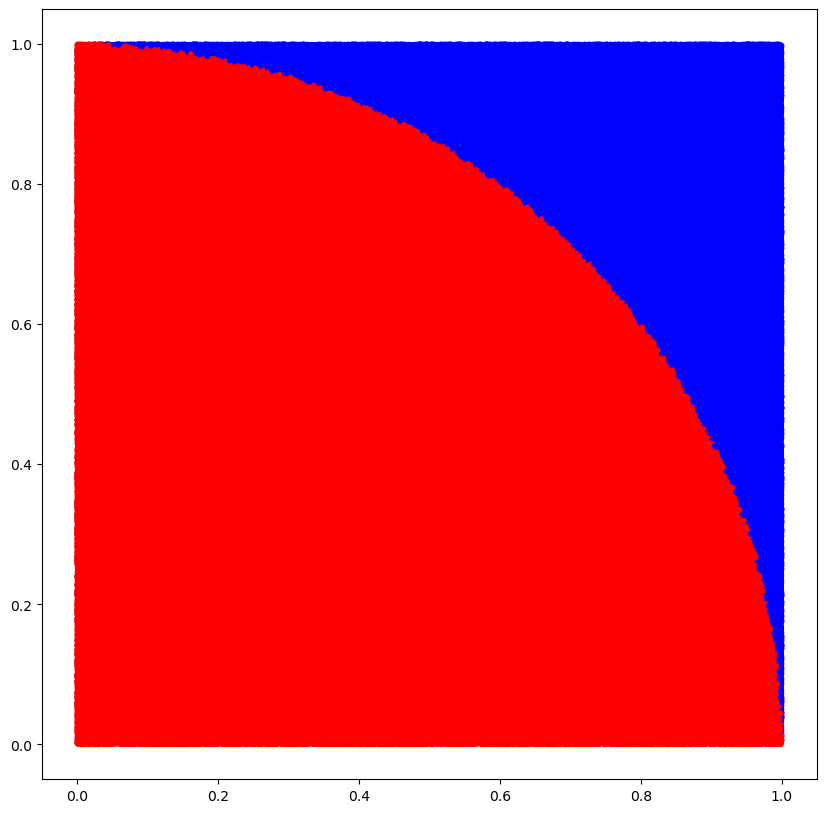

In [70]:
### YOUR ANSWER HERE

#10
import matplotlib.pyplot as plt
import numpy as np
pts10x = st.uniform.rvs(size=1000000)
pts10y = st.uniform.rvs(size=1000000)
r=np.sqrt(pts10x**2+pts10y**2)
color1 = []
counter = 0
for i in r:
    if i>1:
        color1.append("b")
    else:
        color1.append("r")
        counter+=1
plt.scatter(pts10x,pts10y, c = color1,marker = '.')

pi = 4*counter/len(pts10x)
pi

In [42]:
r

array([0.72021549, 0.92363501, 0.93982738, 0.74073339, 1.01264406,
       0.82636061, 0.97525971, 0.82561392, 0.66192672, 0.95629269])

![Conditional probability](conditional_prob3.png)
Courtesy: Federica Bianco

* Simple MC with uniform sampling of parameter space **does not solve curse of dimensionality (too many useless samples in low likelihood region)** 
* What if, instead of sampling the parameter space uniformly, you could sample the posterior directly
    * Possible outcomes would be **simulated with a frequency proportional to the probability**
    
<table>
    <tr>
        <td><img src="Likelihood_Surface.png" width=100%></td>
    </tr>
</table>

There are a couple of approaches to this:
 
### 1. Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

Visually, this corresponds to drawing points that uniformly fill in the space under $p(x)$.

<table>
    <tr>
        <td><img src="mc1_rejection.png" width=100%></td>
    </tr>
</table>
Courtesy: Phil Marshall

The second approach you've already seen and used a lot:

### 2. The Inverse Transform 

The definition of the CDF (and it's inverse, $F^{-1}$, the quantile function - i.e. `ppf()` in `scipy.stats`) 

$F(x) = P(X \leq x) = \int_{-\infty}^x p(x')\,dx'$

By this definition, quantiles of $X$ are uniformly distributed on [0,1]. If $F^{-1}$ is easy to evaluate, we can use this straightforwardly:

```
draw u from Uniform(0,1)
compute x = F_inverse(u)
```




* This does solve the problem posed by the curse of dimensionality 

* No sample is rejected! 

* The con is that you have to know what p(x) looks like in advance

* If p(x) is your posterior, then you not only need to be able to solve for it analytically (including the evidence - the denominator of Bayes' theorem) but then you've got to figure out how to invert it... even harder.
    
* There is a place for the PIT, but we started down this road because our functions weren't generally going to be nice, so lets deal with rejection sampling some more

# We want a couple of properties

* We want to sample the full distribution 
* We want the frequency of samples between $x$ and $x+dx$ to be proportional to $p(x)dx$

What if, instead of drawing i.i.d samples, we drew samples such that they are correlated with each other.

You have already seen examples of processes where samples are correlated with each other - Brownian motion/random walks/Wiener processes - all of these are examples of **stochastic** processes
<table>
    <tr>
        <td><img src="Wiener_process_3d.png" width=100%></td>
    </tr>
</table>

 What if we chose our samples to be correlated in a very specific way:
   * decide how many samples you want
   * start somewhere - we'll call our current position in k-dimensional parameter space $x$
   * while you want samples:
       * perturb $x$ to $x'$ by some random vector drawn from a fixed distribution   
           * i.e. the samples are correlated
       * evaluate your function at $x'$ and $x$
       * if the function is higher at $x'$ than at $x$ 
           * then yay! Accept it, and set the position $x'$ to the current position $x$
       * else if the function is lower at $x'$ than at $x$
           * well maybe that's bad, or maybe we're just unlucky and there's good samples to be had near here
           * How do we decide? Well let's draw a random number and check if our function ratio is better or worse
               * if it's better, accept and set the position $x'$ to the current position $x$
               * else reject and update the current position to be the same 
       * stick the current position after you did this into a list of samples 
    
This sequence/list of all accepted samples is a **chain**

This is just our **rejection sampling** strategy (recall):

```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Markov Chains:

If we can construct a sequence of samples/chain this way, it will be **ergodic** - i.e. given enough time, the full distribution will be sampled

This chain is from some n-dimensional parameter space, with a distribution that is asymptotically proportional to $p(x)$. 

**(NOTE THAT I SHOULD REALLY BE WRITING $\theta$ NOT $x$ BUT YOU TRYING DOING THIS OVER AND OVER!)**

The constant of proportionality is not important in the first class of problems we will look at. 

In model comparison problems, the proportionality constant must be known. We've glossed over that so far, so we will blithely push forward.

With our particular strategy, every n+1 th position on the chain depends **only** on the nth position:

<table>
    <tr>
        <td><img src="MarkovChain.png" width=100%></td>
    </tr>
</table>

Chains that have this property are called **Markov Chains**.

The **state space** of this stochastic process is the set of all possible values

## Go here:
[http://setosa.io/ev/markov-chains/](http://setosa.io/ev/markov-chains/)

* If you have a finite state space, then you write down transition probabilities from one state to another as a matrix or represent it with a graph

* Usually in science, our parameters do not have discrete states, but take values from the set of real numbers,  ${\rm I\!R}$ - i.e. there are an (uncountably) infinite number of states, and we don't have single dimensional problems

    * Can't represent this as a matrix/graph anymore
    
* Essential elements of this theory still hold in an infinite dimensional state space.

As long as the Markov chain is **positive recurrent** (i.e. you can get to any parameter in a finite number of steps) and is **irreducible** (you can get to every parameter value from every other parameter value) then it has another nice property  - it is **stationary** 

A subset of Markov Chains are **stationary**

<table>
    <tr>
        <td><img src="StationaryMarkovChain.png" width=100%></td>
    </tr>
</table>


The average of some function over the samples in the Markov chain is asymptotically equal to the expectation value of the function over the underlying stationary distribution.

<table>
    <tr>
        <td><img src="ReversibleMarkovChain.png" width=100%></td>
    </tr>
</table>

### **All reversible chains are stationary, but not vice-versa!** 

The particular algorithm for generating new samples (more properly detailed in HW4) is called **Metropolis-Hastings** after the folks that came up with it.

In summary, the Metropolis-Hastings algorithm consists of these steps:

1. given $x$ and $T(x'|x)$, draw a proposed value for $x'$

2. compute acceptance probability $p_{\rm acc}(x,x')$.

3. draw a random number between 0 and 1 from a uniform distribution; if it smaller than $p_{\rm acc}(x,x')$, then accept $x'$.

4. if $x'$ is accepted added it to the chain, if not, add $x'$ to the chain.

In [71]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Vv3f0QNWvWQ?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


/Users/arw/miniconda3/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This process is NOT **stationary**. 

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $x'$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!

How far should we step (small steps in parameter space or large). This impacts the efficiency of the process but not if we will reach equilibrium.

<table>
    <tr>
        <td><img src="sampling.png" width=100%></td>
    </tr>
</table>


# <center>"Well that's easy, MCMC generates samples from the posterior distribution by constructing an ergodic, reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?" </center>
### <center> - Thomas Wiecki, very tongue in cheek </center>

https://twiecki.io/blog/2015/11/10/mcmc-sampling/